# Prediction of usability of a running track

#### We develop a model that predicts the probability of a running track to be apt to use depending on the temperature and humidity of the enviroment.

We load the dataset and explore some of its statistics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import hinge_loss, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf

In [2]:
data = pd.read_csv('df_noisy.csv', sep=',', index_col=0)
data = shuffle(data)
data

,temperatura,humedad,corre
573,25,32,si
620,6,43,si
32,36,91,no
318,28,85,no
274,22,86,no
...,...,...,...
403,26,30,si
168,5,82,no
67,19,37,si
121,9,91,no


In [3]:
data.loc[:, ['corre']] = data.loc[:, ['corre']].applymap(lambda x:1. if x=='si' else 0.)
data

,temperatura,humedad,corre
573,25,32,1.0
620,6,43,1.0
32,36,91,0.0
318,28,85,0.0
274,22,86,0.0
...,...,...,...
403,26,30,1.0
168,5,82,0.0
67,19,37,1.0
121,9,91,0.0


In [4]:
data.count()

temperatura    650
humedad        650
corre          650
dtype: int64

In [5]:
data.loc[:,'corre'].value_counts()

0.0    335
1.0    315
Name: corre, dtype: int64

Text(0.5, 1.0, 'corre')

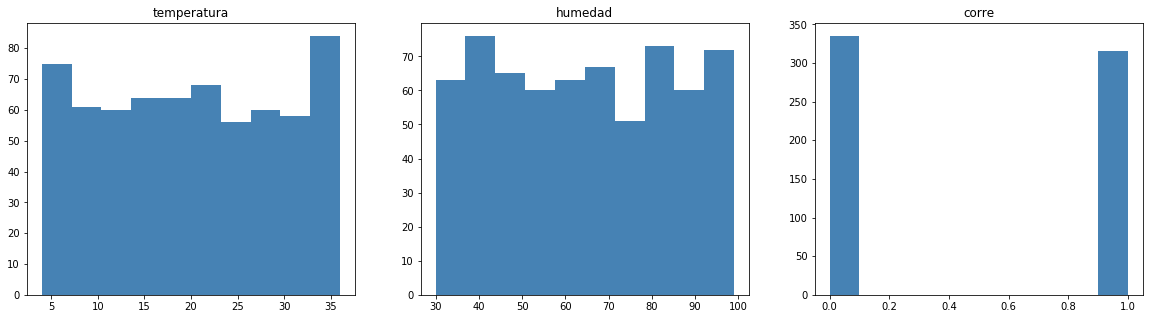

In [6]:
fig = plt.figure(figsize=(20, 5))
ax11 = fig.add_subplot(1, 3, 1)
ax11.hist(data.loc[:, 'temperatura'], histtype='stepfilled', color='steelblue', edgecolor='none')
ax11.set_title('temperatura')
ax12 = fig.add_subplot(1, 3, 2)
ax12.hist(data.loc[:, 'humedad'], histtype='stepfilled', color='steelblue', edgecolor='none')
ax12.set_title('humedad')
ax21 = fig.add_subplot(1, 3, 3)
ax21.hist(data.loc[:, 'corre'], histtype='stepfilled', color='steelblue', edgecolor='none')
ax21.set_title('corre')

The dataset is quite clean and well balanced in each class so we procede to the other steps in preparation for training a model.

-----

Here we define the datasets for training and testing. We need to check that the partition gives well balanced results for each class.

In [7]:
X = data.iloc[:,[0,1]].values
Y = data.iloc[:,[2]].values

X_train = data.iloc[:520,[0,1]].values
Y_train = data.iloc[:520,[2]].values

X_test = data.iloc[520:,[0,1]].values
Y_test = data.iloc[520:,[2]].values

In [8]:
(np.sum(Y_train)*100)/520

48.26923076923077

In [9]:
(np.sum(Y_test)*100)/130

49.23076923076923

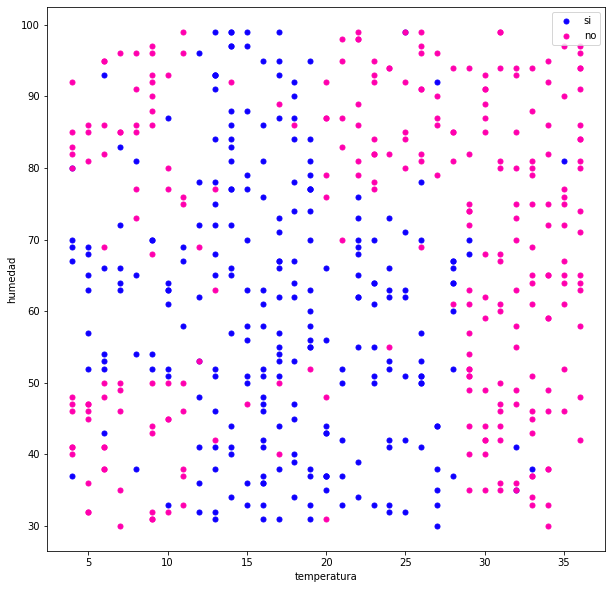

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('temperatura')
ax.set_ylabel('humedad')
pos = np.where(Y_train[:,0] == 1)[0]
neg = np.where(Y_train[:,0] == 0)[0]
ax.plot(X_train[pos,0], X_train[pos,1], marker='.', color='#0F00FF', markersize=10, linestyle='', label='si') 
ax.plot(X_train[neg,0], X_train[neg,1], marker='.', color='#FF00AE', markersize=10, linestyle='', label='no')
ax.legend()

-----

This function plots the results of the model obtained after training. It will be used for each model we train.

In [11]:
def plot_model(model):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.axis([np.min(X_train[:,0])-0.1, np.max(X_train[:,0])+0.1, np.min(X_train[:,1])-0.1, np.max(X_train[:,1])+0.1])
    u = np.linspace(np.min(X_train[:,0])-0.1, np.max(X_train[:,0])+0.1, 100)
    v = np.linspace(np.min(X_train[:,1])-0.1, np.max(X_train[:,1])+0.1, 100)
    z = []
    for i in range(100):
        for j in range(100):
            z.append([u[i], v[j]])
    z = np.array(z)
    w = (model.predict(z).flatten()>0.5).astype(int)
    model_pos = np.where(w == 1)[0]
    model_neg = np.where(w == 0)[0]
    ax.plot(z[model_pos,0], z[model_pos,1], marker='+', color='#C7C3FF', markersize=10, linestyle='')
    ax.plot(z[model_neg,0], z[model_neg,1], marker='+', color='#FFECFB', markersize=10, linestyle='')
    pos = np.where(Y_train[:,0] == 1)[0]
    neg = np.where(Y_train[:,0] == 0)[0]
    ax.plot(X_train[pos,0], X_train[pos,1], marker='.', color='#0F00FF', markersize=10, linestyle='', label='si') 
    ax.plot(X_train[neg,0], X_train[neg,1], marker='.', color='#FF00AE', markersize=10, linestyle='', label='no')
    ax.legend()

This function plots the confusion matrix of the model predictions.

In [12]:
def plot_confusion_matrix(model):    
    cm = confusion_matrix(Y_test.flatten(), model.predict(X_test).flatten()>0.5, labels=[1.,0.])
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('PREDICTED')
    ax.set_ylabel('ACTUAL')
    ax.set_xticklabels(2*['']+['Positive']+3*['']+['Negative']+2*[''])
    ax.set_yticklabels(2*['']+['Positive']+3*['']+['Negative']+2*[''])
    ax.text(0., 0., str(cm[0,0]), fontsize=40, color='white', horizontalalignment='center', verticalalignment='center')
    ax.text(1., 0., str(cm[0,1]), fontsize=40, color='white', horizontalalignment='center', verticalalignment='center')
    ax.text(0., 1., str(cm[1,0]), fontsize=40, color='white', horizontalalignment='center', verticalalignment='center')
    ax.text(1., 1., str(cm[1,1]), fontsize=40, color='white', horizontalalignment='center', verticalalignment='center')
    ax.imshow(cm)

-----

Here we train a knn model just to have a baseline model. We show how is performing on the train and test set to see if it is overfitting. Finally we plot the classification results.

In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train.flatten())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [14]:
knn.score(X_train, Y_train.flatten())

0.9019230769230769

In [15]:
knn.score(X_test, Y_test.flatten())

0.8538461538461538

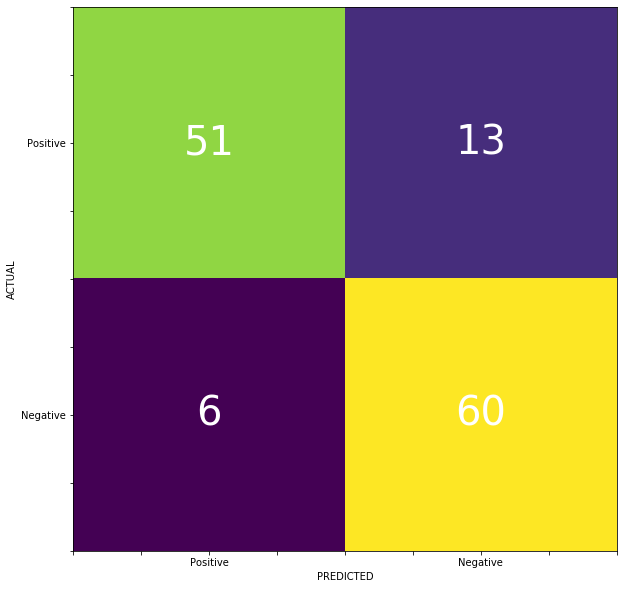

In [16]:
plot_confusion_matrix(knn)

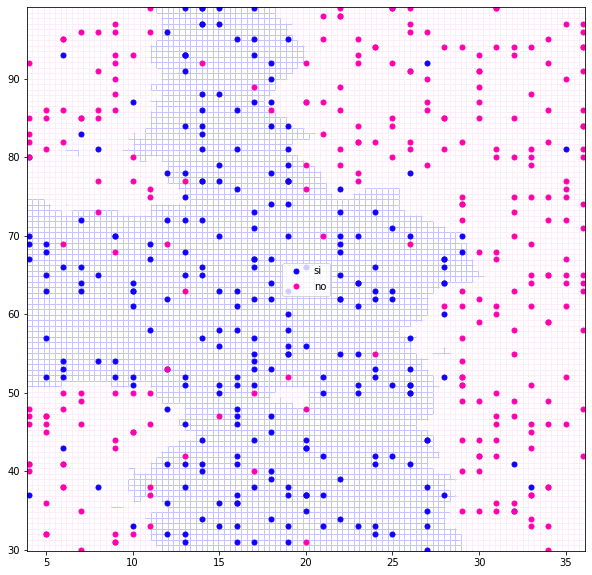

In [17]:
plot_model(knn)

This model is drastically overfitting. Nevertheless, we propose it as the baseline model to beat.

-----

Here we train a svm model with gaussian kernel. We show how is performing on the train and test set to see if it is overfitting. Finally we plot the classification results.

In [18]:
class GaussianKernel():
    def __init__(self, K, sigma):
        self.K = K
        self.sigma = sigma
    def __call__(self, inputs):
        l1 = self.K.shape[0]
        l2 = inputs.shape[0]
        result = np.zeros((l1,l2))
        for i in range(l1):
            for j in range(l2):
                z = np.sum(np.power(self.K[i,:] - inputs[j,:], 2))
                result[i,j] = np.exp(-z/(2*np.power(self.sigma,2)))
        return result.T
    

svm = Pipeline([('gaussian_kernel', FunctionTransformer(GaussianKernel(K=X_train, sigma=10.))),
                  ('svm', SVC(C=1., kernel='linear', max_iter=10000))])

svm.fit(X_train, Y_train.flatten())

Pipeline(memory=None,
         steps=[('gaussian_kernel',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<__main__.GaussianKernel object at 0x7fcdb1469c50>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='linear', max_iter=10000,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [19]:
accuracy_score(Y_train, svm.predict(X_train))

0.8961538461538462

In [20]:
accuracy_score(Y_test, svm.predict(X_test))

0.8615384615384616

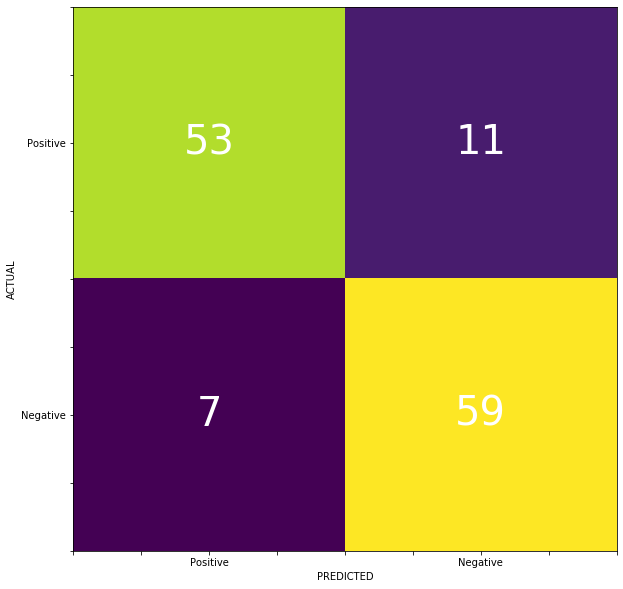

In [21]:
plot_confusion_matrix(svm)

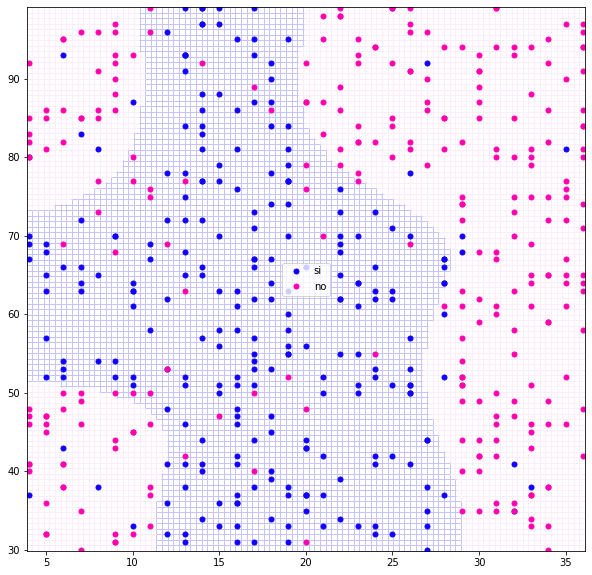

In [22]:
plot_model(svm)

This model is perfoming a bit worse than the baseline model on the training set but it is overfitting less so we propose it as the new baseline model to beat.

-----

Here we train a decision tree classifier. We show how is performing on the train and test set to see if it is overfitting. Finally we plot the classification results.

In [23]:
tree = DecisionTreeClassifier()
tree.fit(X_train, Y_train.flatten())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [24]:
tree.score(X_train, Y_train.flatten())

0.9923076923076923

In [25]:
tree.score(X_test, Y_test.flatten())

0.8692307692307693

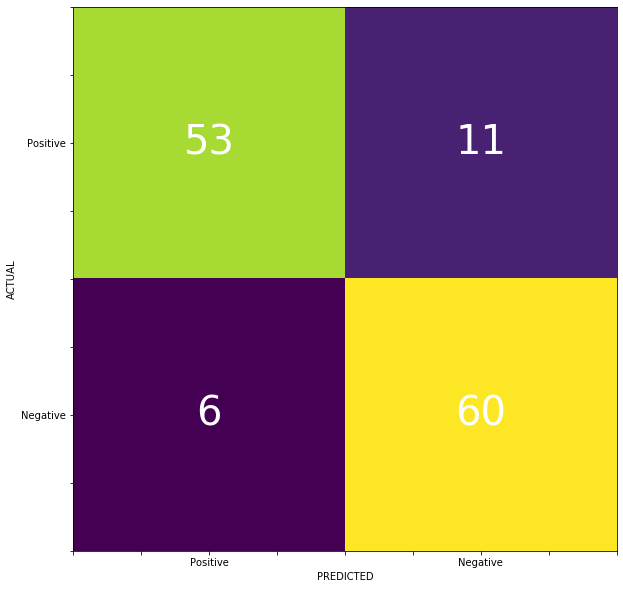

In [26]:
plot_confusion_matrix(tree)

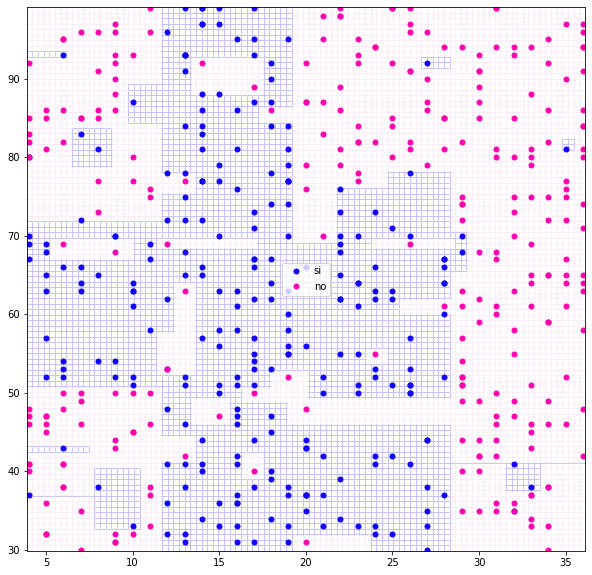

In [27]:
plot_model(tree)

This model is performing much better than the baseline model on the training set. Unfortunately, is severely overfitting (as decision trees usually do) so we discard it.

-----

Here we train the last model, a neural network. We show how is performing on the train and test set to see if it is overfitting. Finally we plot the classification results.

In [28]:
mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0)

In [29]:
def Model(dims, verbose, X, Y):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Lambda(function=lambda x: (x-mu)/sigma,
                                     input_shape=[dims[0]]))
    for dim in dims[1:-1]:
        model.add(tf.keras.layers.Dense(units=dim, 
                                        activation='relu', 
                                        kernel_initializer='he_uniform', 
                                        bias_initializer='zeros'))
        model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(dims[-1], 
                                    activation='sigmoid', 
                                    kernel_initializer='he_uniform', 
                                    bias_initializer='zeros'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, 
                                         beta_1=0.9, 
                                         beta_2=0.999, 
                                         epsilon=1e-07)
    model.compile(loss='binary_crossentropy', metrics=['binary_accuracy'], optimizer=optimizer)
    if verbose:
        model.summary()
    callback1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                     patience=100,
                                                     min_delta=0.001,
                                                     factor=0.1, 
                                                     min_lr=0.0001)
    callback2 = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                 patience=200,
                                                 min_delta=0.001)
    model.fit(X, Y, epochs=1000, batch_size=32, callbacks=[callback1, callback2], verbose=verbose)
    return model

In [30]:
nn = Model(dims=[X_train.shape[1],64,64,Y_train.shape[1]], 
           verbose=True,
           X=X_train,
           Y=Y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
______________________________________________________

520/520 [==============================] - 0s 67us/sample - loss: 0.3953 - binary_accuracy: 0.8404
Epoch 64/1000
520/520 [==============================] - 0s 49us/sample - loss: 0.4021 - binary_accuracy: 0.8327
Epoch 65/1000
520/520 [==============================] - 0s 46us/sample - loss: 0.4014 - binary_accuracy: 0.8442
Epoch 66/1000
520/520 [==============================] - 0s 52us/sample - loss: 0.3964 - binary_accuracy: 0.8500
Epoch 67/1000
520/520 [==============================] - 0s 42us/sample - loss: 0.4033 - binary_accuracy: 0.8404
Epoch 68/1000
520/520 [==============================] - 0s 53us/sample - loss: 0.3834 - binary_accuracy: 0.8519
Epoch 69/1000
520/520 [==============================] - 0s 49us/sample - loss: 0.4223 - binary_accuracy: 0.8288
Epoch 70/1000
520/520 [==============================] - 0s 49us/sample - loss: 0.3925 - binary_accuracy: 0.8500
Epoch 71/1000
520/520 [==============================] - 0s 50us/sample - loss: 0.4280 - binary_accuracy: 0.84

520/520 [==============================] - 0s 56us/sample - loss: 0.4098 - binary_accuracy: 0.8404
Epoch 136/1000
520/520 [==============================] - 0s 53us/sample - loss: 0.3752 - binary_accuracy: 0.8442
Epoch 137/1000
520/520 [==============================] - 0s 46us/sample - loss: 0.4105 - binary_accuracy: 0.8827
Epoch 138/1000
520/520 [==============================] - 0s 51us/sample - loss: 0.3748 - binary_accuracy: 0.8462
Epoch 139/1000
520/520 [==============================] - 0s 49us/sample - loss: 0.3842 - binary_accuracy: 0.8481
Epoch 140/1000
520/520 [==============================] - 0s 49us/sample - loss: 0.3686 - binary_accuracy: 0.8577
Epoch 141/1000
520/520 [==============================] - 0s 56us/sample - loss: 0.4123 - binary_accuracy: 0.8462
Epoch 142/1000
520/520 [==============================] - 0s 54us/sample - loss: 0.3766 - binary_accuracy: 0.8308
Epoch 143/1000
520/520 [==============================] - 0s 54us/sample - loss: 0.3793 - binary_accura

Epoch 207/1000
520/520 [==============================] - 0s 55us/sample - loss: 0.3716 - binary_accuracy: 0.8750
Epoch 208/1000
520/520 [==============================] - 0s 50us/sample - loss: 0.3630 - binary_accuracy: 0.8500
Epoch 209/1000
520/520 [==============================] - 0s 57us/sample - loss: 0.3661 - binary_accuracy: 0.8712
Epoch 210/1000
520/520 [==============================] - 0s 55us/sample - loss: 0.3823 - binary_accuracy: 0.8635
Epoch 211/1000
520/520 [==============================] - 0s 46us/sample - loss: 0.4020 - binary_accuracy: 0.8500
Epoch 212/1000
520/520 [==============================] - 0s 59us/sample - loss: 0.3793 - binary_accuracy: 0.8596
Epoch 213/1000
520/520 [==============================] - 0s 55us/sample - loss: 0.3648 - binary_accuracy: 0.8673
Epoch 214/1000
520/520 [==============================] - 0s 48us/sample - loss: 0.3960 - binary_accuracy: 0.8808
Epoch 215/1000
520/520 [==============================] - 0s 55us/sample - loss: 0.3625 

520/520 [==============================] - 0s 52us/sample - loss: 0.3871 - binary_accuracy: 0.8673
Epoch 279/1000
520/520 [==============================] - 0s 44us/sample - loss: 0.3684 - binary_accuracy: 0.8673
Epoch 280/1000
520/520 [==============================] - 0s 51us/sample - loss: 0.3702 - binary_accuracy: 0.8731
Epoch 281/1000
520/520 [==============================] - 0s 57us/sample - loss: 0.3848 - binary_accuracy: 0.8596
Epoch 282/1000
520/520 [==============================] - 0s 52us/sample - loss: 0.3779 - binary_accuracy: 0.8596
Epoch 283/1000
520/520 [==============================] - 0s 50us/sample - loss: 0.3700 - binary_accuracy: 0.8712
Epoch 284/1000
520/520 [==============================] - 0s 56us/sample - loss: 0.3718 - binary_accuracy: 0.8615
Epoch 285/1000
520/520 [==============================] - 0s 52us/sample - loss: 0.3809 - binary_accuracy: 0.8692
Epoch 286/1000
520/520 [==============================] - 0s 52us/sample - loss: 0.3870 - binary_accura

Epoch 350/1000
520/520 [==============================] - 0s 49us/sample - loss: 0.3911 - binary_accuracy: 0.8731
Epoch 351/1000
520/520 [==============================] - 0s 48us/sample - loss: 0.3583 - binary_accuracy: 0.8769
Epoch 352/1000
520/520 [==============================] - 0s 45us/sample - loss: 0.3587 - binary_accuracy: 0.8654
Epoch 353/1000
520/520 [==============================] - 0s 50us/sample - loss: 0.3637 - binary_accuracy: 0.8673
Epoch 354/1000
520/520 [==============================] - 0s 47us/sample - loss: 0.3452 - binary_accuracy: 0.8750
Epoch 355/1000
520/520 [==============================] - 0s 54us/sample - loss: 0.3913 - binary_accuracy: 0.8577
Epoch 356/1000
520/520 [==============================] - 0s 53us/sample - loss: 0.3514 - binary_accuracy: 0.8769
Epoch 357/1000
520/520 [==============================] - 0s 53us/sample - loss: 0.3608 - binary_accuracy: 0.8538
Epoch 358/1000
520/520 [==============================] - 0s 50us/sample - loss: 0.3706 

520/520 [==============================] - 0s 53us/sample - loss: 0.3471 - binary_accuracy: 0.8865
Epoch 422/1000
520/520 [==============================] - 0s 57us/sample - loss: 0.3665 - binary_accuracy: 0.8769
Epoch 423/1000
520/520 [==============================] - 0s 57us/sample - loss: 0.3670 - binary_accuracy: 0.8692
Epoch 424/1000
520/520 [==============================] - 0s 58us/sample - loss: 0.3359 - binary_accuracy: 0.8904
Epoch 425/1000
520/520 [==============================] - 0s 52us/sample - loss: 0.3568 - binary_accuracy: 0.8577
Epoch 426/1000
520/520 [==============================] - 0s 55us/sample - loss: 0.3586 - binary_accuracy: 0.8827
Epoch 427/1000
520/520 [==============================] - 0s 54us/sample - loss: 0.3489 - binary_accuracy: 0.8769
Epoch 428/1000
520/520 [==============================] - 0s 54us/sample - loss: 0.3671 - binary_accuracy: 0.8692
Epoch 429/1000
520/520 [==============================] - 0s 69us/sample - loss: 0.3717 - binary_accura

Epoch 493/1000
520/520 [==============================] - 0s 57us/sample - loss: 0.3632 - binary_accuracy: 0.8808
Epoch 494/1000
520/520 [==============================] - 0s 55us/sample - loss: 0.3729 - binary_accuracy: 0.8712
Epoch 495/1000
520/520 [==============================] - 0s 55us/sample - loss: 0.3530 - binary_accuracy: 0.8769
Epoch 496/1000
520/520 [==============================] - 0s 59us/sample - loss: 0.3453 - binary_accuracy: 0.8769
Epoch 497/1000
520/520 [==============================] - 0s 70us/sample - loss: 0.3398 - binary_accuracy: 0.8750
Epoch 498/1000
520/520 [==============================] - 0s 60us/sample - loss: 0.3746 - binary_accuracy: 0.8654
Epoch 499/1000
520/520 [==============================] - 0s 63us/sample - loss: 0.3420 - binary_accuracy: 0.8750
Epoch 500/1000
520/520 [==============================] - 0s 64us/sample - loss: 0.3593 - binary_accuracy: 0.8846
Epoch 501/1000
520/520 [==============================] - 0s 58us/sample - loss: 0.3393 

520/520 [==============================] - 0s 56us/sample - loss: 0.3707 - binary_accuracy: 0.8731
Epoch 565/1000
520/520 [==============================] - 0s 53us/sample - loss: 0.3534 - binary_accuracy: 0.8731
Epoch 566/1000
520/520 [==============================] - 0s 57us/sample - loss: 0.3297 - binary_accuracy: 0.8904
Epoch 567/1000
520/520 [==============================] - 0s 54us/sample - loss: 0.3350 - binary_accuracy: 0.8846
Epoch 568/1000
520/520 [==============================] - 0s 49us/sample - loss: 0.3490 - binary_accuracy: 0.8846
Epoch 569/1000
520/520 [==============================] - 0s 57us/sample - loss: 0.3454 - binary_accuracy: 0.8885
Epoch 570/1000
520/520 [==============================] - 0s 63us/sample - loss: 0.3730 - binary_accuracy: 0.8731
Epoch 571/1000
520/520 [==============================] - 0s 50us/sample - loss: 0.3559 - binary_accuracy: 0.8788
Epoch 572/1000
520/520 [==============================] - 0s 52us/sample - loss: 0.3588 - binary_accura

In [31]:
nn.evaluate(X_train, Y_train)

520/520 [==============================] - 0s 234us/sample - loss: 0.3165 - binary_accuracy: 0.9058


[0.3165422673408802, 0.9057692]

In [32]:
nn.evaluate(X_test, Y_test)

130/130 [==============================] - 0s 52us/sample - loss: 0.4053 - binary_accuracy: 0.8846


[0.4053273033637267, 0.88461536]

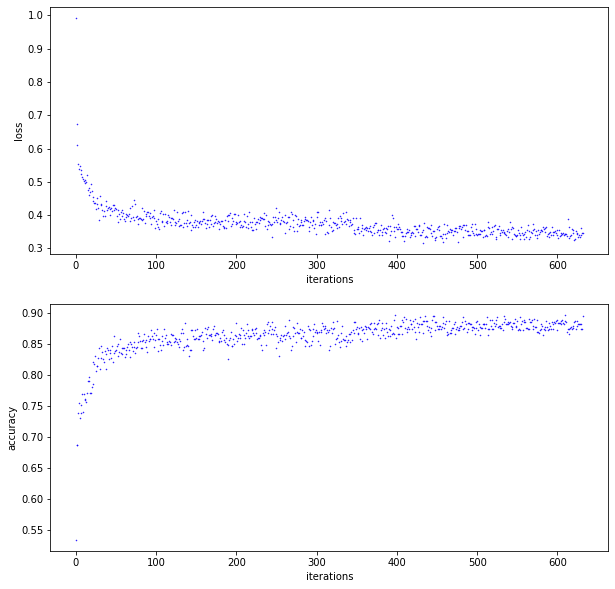

In [33]:
loss = nn.history.history['loss']
accuracy = nn.history.history['binary_accuracy']

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')
ax1.plot(loss, marker='.', color='#0F00FF', markersize=1, linestyle='')

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlabel('iterations')
ax2.set_ylabel('accuracy')
ax2.plot(accuracy, marker='.', color='#0F00FF', markersize=1, linestyle='')

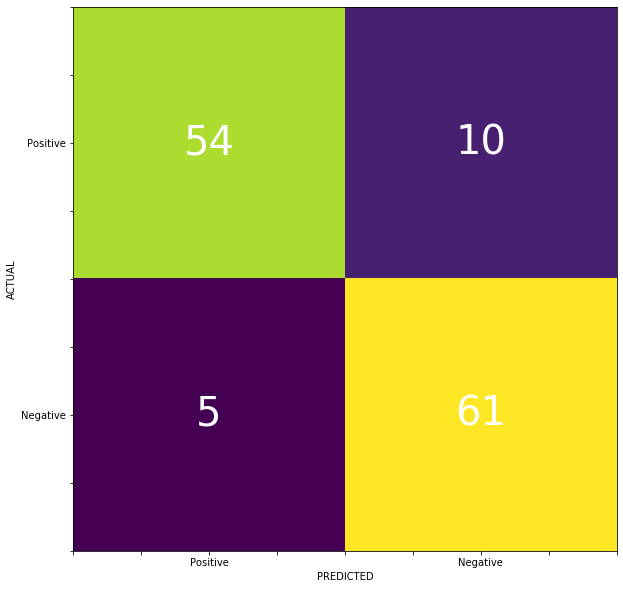

In [34]:
plot_confusion_matrix(nn)

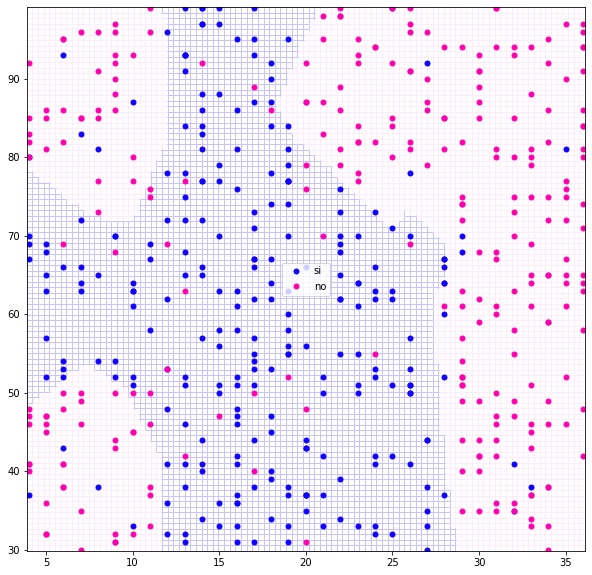

In [35]:
plot_model(nn)

This last model ends up being the best one, beating the baseline model on the training and testing set. Overfitting is occuring but with much less intensity than the previous models. We choose this model as a candidate solution and train it on the whole dataset. Finally, we plot the classification results.

-----

In [36]:
model = Model(dims=[X.shape[1],64,64,Y.shape[1]], 
              verbose=True,
              X=X,
              Y=Y)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                192       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
____________________________________________________

650/650 [==============================] - 0s 55us/sample - loss: 0.3955 - binary_accuracy: 0.8538
Epoch 64/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.4059 - binary_accuracy: 0.8538
Epoch 65/1000
650/650 [==============================] - 0s 45us/sample - loss: 0.4037 - binary_accuracy: 0.8446
Epoch 66/1000
650/650 [==============================] - 0s 43us/sample - loss: 0.3939 - binary_accuracy: 0.8523
Epoch 67/1000
650/650 [==============================] - 0s 52us/sample - loss: 0.4088 - binary_accuracy: 0.8631
Epoch 68/1000
650/650 [==============================] - 0s 54us/sample - loss: 0.4052 - binary_accuracy: 0.8569
Epoch 69/1000
650/650 [==============================] - 0s 59us/sample - loss: 0.3863 - binary_accuracy: 0.8692
Epoch 70/1000
650/650 [==============================] - 0s 55us/sample - loss: 0.3814 - binary_accuracy: 0.8600
Epoch 71/1000
650/650 [==============================] - 0s 56us/sample - loss: 0.3998 - binary_accuracy: 0.86

650/650 [==============================] - 0s 65us/sample - loss: 0.3589 - binary_accuracy: 0.8877
Epoch 136/1000
650/650 [==============================] - 0s 55us/sample - loss: 0.3900 - binary_accuracy: 0.8662
Epoch 137/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3678 - binary_accuracy: 0.8815
Epoch 138/1000
650/650 [==============================] - 0s 52us/sample - loss: 0.3816 - binary_accuracy: 0.8508
Epoch 139/1000
650/650 [==============================] - 0s 49us/sample - loss: 0.3590 - binary_accuracy: 0.8800
Epoch 140/1000
650/650 [==============================] - 0s 54us/sample - loss: 0.3563 - binary_accuracy: 0.8692
Epoch 141/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.4291 - binary_accuracy: 0.8538
Epoch 142/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3971 - binary_accuracy: 0.8523
Epoch 143/1000
650/650 [==============================] - 0s 47us/sample - loss: 0.3727 - binary_accura

Epoch 207/1000
650/650 [==============================] - 0s 54us/sample - loss: 0.3622 - binary_accuracy: 0.8723
Epoch 208/1000
650/650 [==============================] - 0s 56us/sample - loss: 0.3845 - binary_accuracy: 0.8785
Epoch 209/1000
650/650 [==============================] - 0s 60us/sample - loss: 0.3553 - binary_accuracy: 0.8862
Epoch 210/1000
650/650 [==============================] - 0s 56us/sample - loss: 0.3786 - binary_accuracy: 0.8615
Epoch 211/1000
650/650 [==============================] - 0s 55us/sample - loss: 0.3685 - binary_accuracy: 0.8677
Epoch 212/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.3477 - binary_accuracy: 0.8892
Epoch 213/1000
650/650 [==============================] - 0s 50us/sample - loss: 0.3567 - binary_accuracy: 0.8892
Epoch 214/1000
650/650 [==============================] - 0s 48us/sample - loss: 0.3620 - binary_accuracy: 0.8677
Epoch 215/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.3726 

650/650 [==============================] - 0s 54us/sample - loss: 0.3190 - binary_accuracy: 0.8815
Epoch 279/1000
650/650 [==============================] - 0s 62us/sample - loss: 0.3719 - binary_accuracy: 0.8631
Epoch 280/1000
650/650 [==============================] - 0s 67us/sample - loss: 0.3481 - binary_accuracy: 0.8769
Epoch 281/1000
650/650 [==============================] - 0s 58us/sample - loss: 0.3798 - binary_accuracy: 0.8662
Epoch 282/1000
650/650 [==============================] - 0s 50us/sample - loss: 0.3756 - binary_accuracy: 0.8800
Epoch 283/1000
650/650 [==============================] - 0s 46us/sample - loss: 0.3522 - binary_accuracy: 0.8769
Epoch 284/1000
650/650 [==============================] - 0s 49us/sample - loss: 0.3711 - binary_accuracy: 0.8785
Epoch 285/1000
650/650 [==============================] - 0s 50us/sample - loss: 0.3480 - binary_accuracy: 0.8785
Epoch 286/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3713 - binary_accura

Epoch 350/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3707 - binary_accuracy: 0.8815
Epoch 351/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3986 - binary_accuracy: 0.8738
Epoch 352/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3596 - binary_accuracy: 0.8723
Epoch 353/1000
650/650 [==============================] - 0s 52us/sample - loss: 0.3663 - binary_accuracy: 0.8708
Epoch 354/1000
650/650 [==============================] - 0s 52us/sample - loss: 0.3941 - binary_accuracy: 0.8677
Epoch 355/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3436 - binary_accuracy: 0.8785
Epoch 356/1000
650/650 [==============================] - 0s 48us/sample - loss: 0.3509 - binary_accuracy: 0.8862
Epoch 357/1000
650/650 [==============================] - 0s 50us/sample - loss: 0.3513 - binary_accuracy: 0.8877
Epoch 358/1000
650/650 [==============================] - 0s 54us/sample - loss: 0.3877 

650/650 [==============================] - 0s 51us/sample - loss: 0.3241 - binary_accuracy: 0.9000
Epoch 422/1000
650/650 [==============================] - 0s 47us/sample - loss: 0.3629 - binary_accuracy: 0.8862
Epoch 423/1000
650/650 [==============================] - 0s 46us/sample - loss: 0.3476 - binary_accuracy: 0.8938
Epoch 424/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3159 - binary_accuracy: 0.8969
Epoch 425/1000
650/650 [==============================] - 0s 48us/sample - loss: 0.3300 - binary_accuracy: 0.8923
Epoch 426/1000
650/650 [==============================] - 0s 48us/sample - loss: 0.3219 - binary_accuracy: 0.9000
Epoch 427/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3238 - binary_accuracy: 0.9000
Epoch 428/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.3231 - binary_accuracy: 0.8938
Epoch 429/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.3261 - binary_accura

Epoch 493/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3244 - binary_accuracy: 0.9000
Epoch 494/1000
650/650 [==============================] - 0s 50us/sample - loss: 0.3103 - binary_accuracy: 0.9062
Epoch 495/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.3244 - binary_accuracy: 0.9077
Epoch 496/1000
650/650 [==============================] - 0s 54us/sample - loss: 0.3269 - binary_accuracy: 0.8954
Epoch 497/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3049 - binary_accuracy: 0.9000
Epoch 498/1000
650/650 [==============================] - 0s 48us/sample - loss: 0.3299 - binary_accuracy: 0.8938
Epoch 499/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.3068 - binary_accuracy: 0.8969
Epoch 500/1000
650/650 [==============================] - 0s 52us/sample - loss: 0.3293 - binary_accuracy: 0.8954
Epoch 501/1000
650/650 [==============================] - 0s 55us/sample - loss: 0.3354 

650/650 [==============================] - 0s 49us/sample - loss: 0.2786 - binary_accuracy: 0.9123
Epoch 565/1000
650/650 [==============================] - 0s 49us/sample - loss: 0.3196 - binary_accuracy: 0.8985
Epoch 566/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.3276 - binary_accuracy: 0.8954
Epoch 567/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3047 - binary_accuracy: 0.9031
Epoch 568/1000
650/650 [==============================] - 0s 49us/sample - loss: 0.3287 - binary_accuracy: 0.8938
Epoch 569/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3495 - binary_accuracy: 0.8923
Epoch 570/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3517 - binary_accuracy: 0.8892
Epoch 571/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.3208 - binary_accuracy: 0.9015
Epoch 572/1000
650/650 [==============================] - 0s 49us/sample - loss: 0.3176 - binary_accura

Epoch 636/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.3140 - binary_accuracy: 0.8985
Epoch 637/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3167 - binary_accuracy: 0.8985
Epoch 638/1000
650/650 [==============================] - 0s 48us/sample - loss: 0.3277 - binary_accuracy: 0.8815
Epoch 639/1000
650/650 [==============================] - 0s 49us/sample - loss: 0.3368 - binary_accuracy: 0.8877
Epoch 640/1000
650/650 [==============================] - 0s 50us/sample - loss: 0.3299 - binary_accuracy: 0.8892
Epoch 641/1000
650/650 [==============================] - 0s 52us/sample - loss: 0.3154 - binary_accuracy: 0.9000
Epoch 642/1000
650/650 [==============================] - 0s 68us/sample - loss: 0.3219 - binary_accuracy: 0.8985
Epoch 643/1000
650/650 [==============================] - 0s 47us/sample - loss: 0.3226 - binary_accuracy: 0.9000
Epoch 644/1000
650/650 [==============================] - 0s 47us/sample - loss: 0.3226 

650/650 [==============================] - 0s 57us/sample - loss: 0.3167 - binary_accuracy: 0.8969
Epoch 708/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.2994 - binary_accuracy: 0.8985
Epoch 709/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.3176 - binary_accuracy: 0.8985
Epoch 710/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.3348 - binary_accuracy: 0.8923
Epoch 711/1000
650/650 [==============================] - 0s 47us/sample - loss: 0.3056 - binary_accuracy: 0.9015
Epoch 712/1000
650/650 [==============================] - 0s 48us/sample - loss: 0.3142 - binary_accuracy: 0.8923
Epoch 713/1000
650/650 [==============================] - 0s 51us/sample - loss: 0.3203 - binary_accuracy: 0.8985
Epoch 714/1000
650/650 [==============================] - 0s 53us/sample - loss: 0.3253 - binary_accuracy: 0.8846
Epoch 715/1000
650/650 [==============================] - 0s 52us/sample - loss: 0.3342 - binary_accura

In [37]:
model.evaluate(X, Y)

650/650 [==============================] - 0s 179us/sample - loss: 0.2708 - binary_accuracy: 0.9215


[0.2708319956064224, 0.9215385]

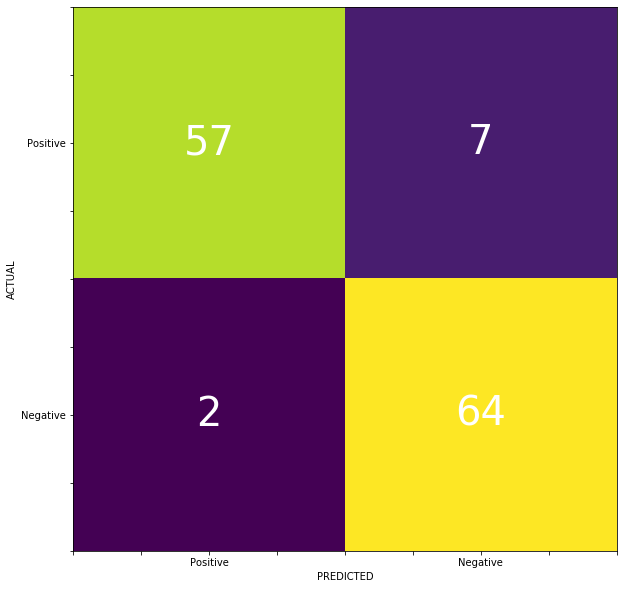

In [38]:
plot_confusion_matrix(model)

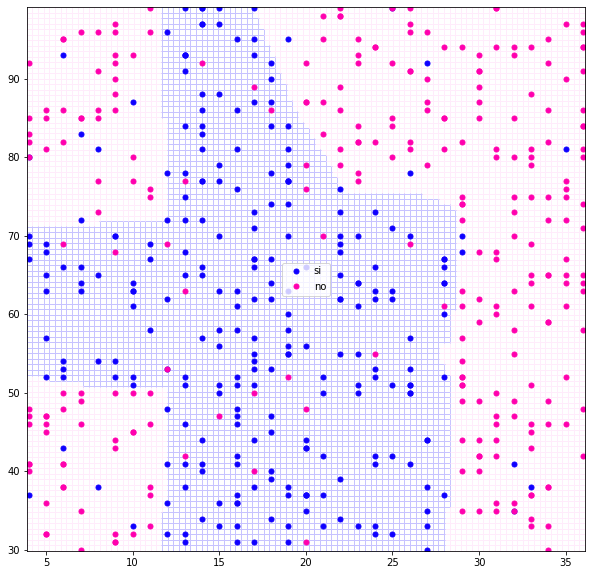

In [39]:
plot_model(model)

#### We propose this last model as the solution for the original problem presented. Some future additional exploration of hyperparameters could be made to see if it is possible to achieve better performance.